# Exercises Week 11-12: Graded exercise session (part B)

**Course**: [Topics in life sciences engineering](https://moodle.epfl.ch/enrol/index.php?id=17061) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

In [56]:
## Import libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import gseapy as gp
import math


from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from adjustText import adjust_text
from scipy.stats import beta

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

### Exercise 1: Simulation of circadian gene regulation

Similarly to Week 9 exercises, we first describe a system in which a (nuclear) pre-mRNA is transcribed and spliced to produce an mRNA. We can write a 2D ODE (ignoring the degradation of the pre-mRNA):

\begin{eqnarray*}
&&\frac{dP}{dt} = s(t) - \rho P \\
&&\frac{dM}{dt} = \rho P - k(t) M \\
\end{eqnarray*}

Here, $P$ and $M$ denote, respectively, the concentrations of pre-mRNA and mRNA. We will consider time-dependent (circadian) transcription and degradation rates. The frequency is $\omega=\frac{2\pi}{T}$ with $T=24h$. $s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a rhythmic function of time:  

\begin{equation*}
s(t) = s_0 (1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that here the peak of $s(t)$ is at $t=0$. 
Similarly, we will consider $k(t)$ either as constant $k(t)= k_0$ or a rhythmic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ is the splicing rate of pre-mRNA $P$ to mRNA $M$, and is also taken as a constant.

### Question 1
1. Adapt the code of week 9 exercises to simulate this new system. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  
2. Keep the degradation rate constant ($\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$. Discuss on how 1) the phase delay between $M(t)$ and $P(t)$ and 2) the relative amplitude of $M(t)$ varies in function of $k_0$. What is the maximal relative amplitude? Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).
3. Vary $\epsilon_k$ to include rhythmic degradation. Discuss the different effects, in particular, find situations that extend beyond what is possible with a constant half-life. See also [Wang et al., 2018](https://www.pnas.org/doi/10.1073/pnas.1715225115).

In [57]:
def transcription_rate(s0,eps_s,t) :
    return s0*(1+ eps_s*np.cos(2*t*math.pi/(24)))

def degradation_rate(k0,eps_k,t,tk) :
    return k0*(1+ eps_k*np.cos((2*math.pi/(24))*(t-tk)))

## function definition
def func(y, t, tk, s0, k0, eps_s, eps_k, rho):
    P, M = y
    return [transcription_rate(s0,eps_s,t) - (rho) * P, rho * P - degradation_rate(k0,eps_k,t,tk) * M]


def simulation(func, par, x0 = None, t = None):
    s0=par['s0']
    k0=par['k0']
    tk = par['tk']
    eps_s=par['eps_s']
    eps_k=par['eps_k']
    rho=par['rho']

    P_ss = transcription_rate(s0,eps_s,t)/(rho) #Steady-state solution for P
    M_ss = transcription_rate(s0,eps_s,t)/degradation_rate(k0,eps_k,t,tk) #Steady-state solution for M

    
    xx=odeint(func, x0, t, args=(tk, s0, k0, eps_s, eps_k, rho))
    plt.figure(1)
    plt.ylim([0,150])
    #plt.axhline(y=np.mean(P_ss), color='r', linestyle='--') # Steady state solution mean for P_ss
    #plt.axhline(y=np.mean(M_ss), color='g', linestyle='--') # Steady state solution mean for M_ss
    plt.plot(t, xx[:,0],label = 'P(t)')
    plt.plot(t, xx[:,1],label = 'M(t)')
    plt.xlabel("time [min]")
    plt.ylabel("#molecules")
    plt.legend()
    plt.show()
    
def animate(x0, time, s0=5, k0= 5, eps_s=0.5, eps_k=0.5, rho=0.5, tk = 50):
    #define the function domain
    par={'s0':s0,'k0':k0, 'eps_s':eps_s, 'rho':rho,'eps_k': eps_k,'tk':tk}
    simulation(func, par, x0, time)

#initial conditions
z0=[0,0] #[P, M]
t = np.linspace(0,100,1001)
interact(animate, x0=fixed(z0), time=fixed(t), 
         s0 = (1,10,0.01), #kp^1 in [10 min, 120 min] 
         k0 = (1,10,0.01), #km^1 in [10 min, 600 min]
         rho = (1/30,1,0.05), #rho^1 in [1 min, 30 min]
         eps_s =(0,1,0.01),
         eps_k = (0,1,0.01),
         tk = (0,100,0.001));

interactive(children=(FloatSlider(value=5.0, description='s0', max=10.0, min=1.0, step=0.01), FloatSlider(valu…

### Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver

We will now analyse published RNA-seq data from mouse liver under an *ad libitum* feeding regimen and in presence of a 12h-12h light-dark cycle ([Atger et al., 2015](https://www.pnas.org/doi/abs/10.1073/pnas.1515308112)). The samples were harvested every 2 hours in four replicates, RNA was extracted and sequenced. Similarly to week 9 exercises on RNA-seq data, gene expression was quantified at the intron and exon levels. Note that data are $log_2$ transformed and normalized (RPKM).

### Question 1
1. Adapt code from week 9 exercises to perform PCA using the 14 following genes (core clock genes and selected clock output genes): ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']``. First start with only the exons, then only the introns, and eventually both. Describe your observations.
2. Using the *return_amp_phase_pv* function with the $log_2$ data, assess rhythmicity genome-wide (use the p-value to make gene selections). For the selected genes, provide histograms of the peak times, and amplitudes ($log_2$ peak-to-trough). Do this separately for the exons and introns. Do you see what's commonly referred to as the morning and evening waves of genes expression?
3. Which genes are overall the most robustly rhythmic? Is there a theme?
3. Adapting the enrichR code from Week 9 exercises, find biological function or transcriptional programs regulated rhythmically in the mouse liver. Do this separately for the night and the day. Comment.

#### Load the RNA-seq data

In [102]:
dat = pd.read_csv("./GSE73554_WT_AL_Intron_Exon_RFP.txt",sep='\t')
dat.index = dat['Gene_Symbol']
dat = dat.drop(['Gene_Symbol','Gene_Ensembl'], axis=1)
dat.columns = dat.columns.str.split('_', expand = True)
dat.columns.names = ['condition','feeding','feature','time','replicate']

dat.head()

condition          WT                                                    \
feeding            AL                                                     
feature        Intron                                                     
time               00        02        04        06        08        10   
replicate           A         A         A         A         A         A   
Gene_Symbol                                                               
Gnai3       -1.564402 -1.536626 -1.931707 -1.458354 -1.575970 -1.654038   
Cdc45       -3.838233 -4.132913 -4.023130 -3.782926 -3.971205 -3.898270   
Apoh        -1.075680 -1.540220 -1.569142 -1.652602 -1.786800 -1.539642   
Narf        -1.198793 -0.937221 -0.921084 -0.331866 -0.123671 -0.186613   
Cav2        -3.046334 -3.741371 -3.364087 -3.063080 -3.374724 -2.992739   

condition                                            ...             \
feeding                                              ...              
feature                                              ...        RFP   
time               12        14        16        18  ...         04   
replicate           A         A         A         A  ...          D   
Gene_Symbol                                          ...              
Gnai3       -1.550707 -1.564596 -1.211372 -1.654187  ...   4.739938   
Cdc45       -3.837377 -3.907227 -4.002231 -3.837719  ...  -1.783427   
Apoh        -1.434320 -1.655522 -1.499171 -1.411709  ...  10.657651   
Narf        -0.632810 -0.963087 -0.999763 -1.320254  ...   1.788997   
Cav2        -2.985271 -2.991166 -2.954387 -3.052015  ...   0.759856   

condition                                                                      \
feeding                                                                         
feature                                                                         
time                06         08         10         12         14         16   
replicate            D          D          D          D          D          D   
Gene_Symbol                                                                     
Gnai3         4.648414   4.576937   4.891934   5.284247   5.502545   5.115915   
Cdc45        -1.045727  -1.868940  -1.616297   1.552717   0.336330  -1.370050   
Apoh         10.460193  10.623698  10.381588  10.146668  10.232355  10.631922   
Narf          2.660656   2.890531   3.379632   2.924193   2.472548   2.686118   
Cav2          0.403964   0.581452   0.716145   0.742948   0.385111   0.282426   

condition                                     
feeding                                       
feature                                       
time                18         20         22  
replicate            D          D          D  
Gene_Symbol                                   
Gnai3         5.402904   5.119890   4.873039  
Cdc45        -0.308212  -1.218384  -0.541827  
Apoh         10.468625  10.704931  10.591210  
Narf          2.390108   1.941836   2.128767  
Cav2          0.624375   0.806800   0.524357  

[5 rows x 144 columns]

In [103]:
# get only the genes we're interested in
genes = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']
all_dat = dat
dat = dat.loc[genes]
i_introns = dat.columns.get_level_values('feature').isin(['Intron'])
dat_intron = dat.iloc[:,i_introns]
i_exons = dat.columns.get_level_values('feature').isin(['Exon'])
dat_exons = dat.iloc[:,i_exons]

i_all = dat.columns.get_level_values('feature').isin(['Intron', 'Exon'])
dat_tot = dat.iloc[:,i_all]

In [104]:
def run_PCA(data, nc=5, x_1=1, x_2=2, col='replicate', shape='time', scale_d=True, log=True):
    pca = PCA(n_components=nc)
    x_1=x_1-1
    x_2=x_2-1
    
    #print(data)

    if(scale_d):
        data_2 = scale(data)
        #print(data_2)
    else:
        data_2 = data

    if(log):
        data_2 =  np.log2(data_2 + 1)
  
    pca.fit(data_2.T)

    labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }


    ## compute PCA and plot
    pca_transformed = pca.transform(data_2.T)
    fig = px.scatter(pca_transformed, x=x_1, y=x_2,
                     color=data.columns.get_level_values(col),
                     symbol=data.columns.get_level_values(shape),
                     width=600, height=600)

    fig.update_traces(marker={'size': 13})
    fig.update_layout(plot_bgcolor = 'rgb(243,243,243)', xaxis_title=labels[str(x_1)],
                      yaxis_title=labels[str(x_2)])
    fig.show()

    df_pca= pd.DataFrame(pca.components_, columns=data.index, index = ['PC-1','PC-2','PC-3','PC-4','PC-5']);

    return df_pca

#Perform the PCA
pca_introns = run_PCA(dat_intron, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_intron, x_1=1, x_2=2, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_intron, x_1=2, x_2=3, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_intron, x_1=2, x_2=3, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_intron, x_1=3, x_2=4, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_intron, x_1=3, x_2=4, col='replicate', shape='feature', scale_d=True, log=False);

In [105]:
pca_all = run_PCA(dat_exons, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=1, x_2=2, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_exons, x_1=2, x_2=3, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=2, x_2=3, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_exons, x_1=3, x_2=4, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=3, x_2=4, col='replicate', shape='feature', scale_d=True, log=False);

In [106]:
pca_all = run_PCA(dat_tot, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_tot, x_1=1, x_2=2, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_tot, x_1=2, x_2=3, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_tot, x_1=2, x_2=3, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_tot, x_1=3, x_2=4, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_tot, x_1=3, x_2=4, col='replicate', shape='feature', scale_d=True, log=False);

#### Assess rhythmicity

In [107]:
# Function to infer the p-value, phase, amplitude and mean from a time-serie y with size N, period T and sampling Ts. 
def return_amp_phase_pv(y, Ts, T, N):
    
    # we do the harmonic regression using a Fourier series
    t = np.linspace(0.0, N * Ts, N)
    x_fft = np.fft.fft(y)
    freq = np.fft.fftfreq(len(y), d=Ts)
    index, = np.where(np.isclose(freq, 1/T, atol=0.005))
    amp = 4 / N * np.abs(x_fft[index[0]])
    phase = T * np.arctan2(-x_fft[index[0]].imag, x_fft[index[0]].real) / (2 * np.pi)
    mu = 1 / N * x_fft[0].real
    
    #compute the residuals and statistics of the fit (pval)
    x_hat = mu + 0.5 * amp * np.cos(2 * np.pi / T * t - 2 * np.pi * phase / T)
    res = y - x_hat
    sig2_1 = np.var(res)
    sig2 = np.var(y)
    R2 = 1 - sig2_1 / sig2
    p = 3
    pval=beta.pdf(R2, (p - 1) / 2, (N - p) / 2)
    if phase < 0:
        phase += T
        
    return amp, phase, pval, mu

In [112]:
all_dat

condition            WT                                                    \
feeding              AL                                                     
feature          Intron                                                     
time                 00        02        04        06        08        10   
replicate             A         A         A         A         A         A   
Gene_Symbol                                                                 
Gnai3         -1.564402 -1.536626 -1.931707 -1.458354 -1.575970 -1.654038   
Cdc45         -3.838233 -4.132913 -4.023130 -3.782926 -3.971205 -3.898270   
Apoh          -1.075680 -1.540220 -1.569142 -1.652602 -1.786800 -1.539642   
Narf          -1.198793 -0.937221 -0.921084 -0.331866 -0.123671 -0.186613   
Cav2          -3.046334 -3.741371 -3.364087 -3.063080 -3.374724 -2.992739   
...                 ...       ...       ...       ...       ...       ...   
D630044L22RIK -4.321928 -4.321928 -4.321928 -4.321928 -4.321928 -4.321928   
Ptges3l       -3.347417 -3.618811 -3.908509 -3.526344 -4.037561 -3.943861   
RP23-206J9.3  -2.691658 -3.027459 -2.962016 -2.628984 -2.712101 -2.554431   
A130051J06Rik -4.321928 -4.321928 -4.321928 -4.321928 -4.321928 -4.321928   
RP24-414A22.6 -3.130522 -2.951066 -3.093629 -2.589265 -2.661218 -2.837659   

condition                                              ...             \
feeding                                                ...              
feature                                                ...        RFP   
time                 12        14        16        18  ...         04   
replicate             A         A         A         A  ...          D   
Gene_Symbol                                            ...              
Gnai3         -1.550707 -1.564596 -1.211372 -1.654187  ...   4.739938   
Cdc45         -3.837377 -3.907227 -4.002231 -3.837719  ...  -1.783427   
Apoh          -1.434320 -1.655522 -1.499171 -1.411709  ...  10.657651   
Narf          -0.632810 -0.963087 -0.999763 -1.320254  ...   1.788997   
Cav2          -2.985271 -2.991166 -2.954387 -3.052015  ...   0.759856   
...                 ...       ...       ...       ...  ...        ...   
D630044L22RIK -4.321928 -4.321928 -3.916656 -4.211345  ...  -4.321928   
Ptges3l       -4.174696 -3.921224 -3.780628 -3.005190  ...  -1.591447   
RP23-206J9.3  -2.718235 -2.661330 -2.389922 -2.353155  ...   1.876491   
A130051J06Rik -4.321928 -3.839064 -4.321928 -4.321928  ...  -3.971570   
RP24-414A22.6 -3.019553 -2.914291 -2.770331 -2.818499  ...   2.722619   

condition                                                             \
feeding                                                                
feature                                                                
time                  06         08         10         12         14   
replicate              D          D          D          D          D   
Gene_Symbol                                                            
Gnai3           4.648414   4.576937   4.891934   5.284247   5.502545   
Cdc45          -1.045727  -1.868940  -1.616297   1.552717   0.336330   
Apoh           10.460193  10.623698  10.381588  10.146668  10.232355   
Narf            2.660656   2.890531   3.379632   2.924193   2.472548   
Cav2            0.403964   0.581452   0.716145   0.742948   0.385111   
...                  ...        ...        ...        ...        ...   
D630044L22RIK  -4.321928  -4.321928  -3.875723  -4.321928  -4.321928   
Ptges3l        -0.918822  -2.252870  -2.462090   0.296977  -0.849123   
RP23-206J9.3    2.159512   2.119404   2.231766   2.003449   1.770509   
A130051J06Rik  -4.321928  -3.154010  -4.052683  -4.064130  -4.073789   
RP24-414A22.6   3.077116   3.173420   2.842354   2.942225   2.968706   

condition                                                  
feeding                                                    
feature                                                    
time                  16         18        

In [113]:
#Apply the function for all the genes at the intron or exon level and retrieve the amplitude, phase, mean and p-value.

Ts = 2.0 # sampling time 
T = 24 # period
N = 48 # number of samples

amp_intron = []
phase_intron = [] 
pv_intron = []
mu_intron = []

i_pos = all_dat.columns.get_level_values('feature').isin(['Intron'])

for i, row in all_dat.iterrows():
    [a, p, pv, mu] = return_amp_phase_pv(np.array(row)[i_pos], Ts, T, N)
    amp_intron.append(a)
    phase_intron.append(p)
    pv_intron.append(pv)
    mu_intron.append(mu)
    
amp_exon = []
phase_exon = [] 
pv_exon = []
mu_exon = []
e_pos = all_dat.columns.get_level_values('feature').isin(['Exon'])

for i, row in all_dat.iterrows():
    [a, p, pv, mu]=return_amp_phase_pv(np.array(row)[e_pos], Ts, T, N)
    amp_exon.append(a)
    phase_exon.append(p)
    pv_exon.append(pv)
    mu_exon.append(mu)

#convert the lists to numpy arrays
phase_intron=np.array(phase_intron)
amp_intron=np.array(amp_intron)
pv_intron=np.array(pv_intron)
mu_intron=np.array(mu_intron)

phase_exon=np.array(phase_exon)
amp_exon=np.array(amp_exon)
pv_exon=np.array(pv_exon)
mu_exon=np.array(mu_exon)

In [114]:
phase_intron

array([21.30599699, 14.28987665,  1.51289669, ..., 18.50873931,
       19.63436034,  8.26927825])

(array([2.037e+03, 3.190e+02, 4.500e+01, 7.000e+00, 2.000e+00, 3.000e+00]),
 array([0.        , 1.02367155, 2.0473431 , 3.07101465, 4.0946862 ,
        5.11835775, 6.1420293 ]),
 <BarContainer object of 6 artists>)

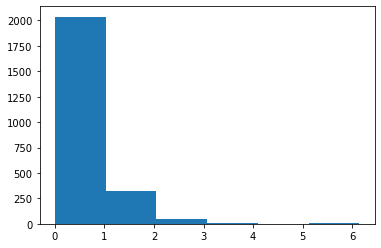

In [116]:
#good_introns = np.asarray(genes)[pv_intron<0.05]
#good_exons = np.asarray(genes)[pv_exon<0.05]

good_introns_amp = amp_intron[pv_intron<0.05]
good_exons_amp = amp_exon[pv_exon<0.05]

good_introns_phase = phase_intron[pv_intron<0.05]
good_exons_phase = phase_exon[pv_exon<0.05]

plt.hist(good_introns_amp,bins=int(max(good_introns_amp)) )

(array([4.573e+03, 4.140e+02, 5.100e+01, 1.200e+01, 2.000e+00, 4.000e+00]),
 array([2.78121639e-04, 1.08997455e+00, 2.17967097e+00, 3.26936739e+00,
        4.35906382e+00, 5.44876024e+00, 6.53845666e+00]),
 <BarContainer object of 6 artists>)

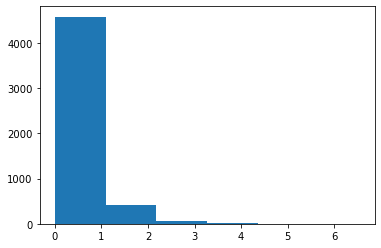

In [117]:
plt.hist(good_exons_amp,bins=int(max(good_exons_amp)))

(array([ 78.,  58.,  43.,  54.,  95., 129., 138., 148., 114., 148., 115.,
        121.,  78.,  72.,  64., 101.,  90., 143., 134., 162., 154., 105.,
         69.]),
 array([ 0.        ,  1.04194603,  2.08389205,  3.12583808,  4.16778411,
         5.20973013,  6.25167616,  7.29362219,  8.33556821,  9.37751424,
        10.41946027, 11.46140629, 12.50335232, 13.54529835, 14.58724437,
        15.6291904 , 16.67113643, 17.71308245, 18.75502848, 19.79697451,
        20.83892053, 21.88086656, 22.92281259, 23.96475861]),
 <BarContainer object of 23 artists>)

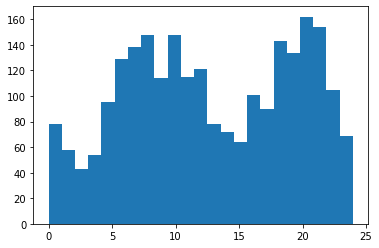

In [118]:
plt.hist(good_introns_phase,bins=int(max(good_introns_phase)))

(array([167., 150., 145., 137., 185., 224., 283., 334., 360., 315., 294.,
        260., 239., 215., 187., 162., 184., 172., 196., 214., 214., 212.,
        207.]),
 array([1.04397847e-03, 1.04447421e+00, 2.08790444e+00, 3.13133467e+00,
        4.17476490e+00, 5.21819513e+00, 6.26162536e+00, 7.30505560e+00,
        8.34848583e+00, 9.39191606e+00, 1.04353463e+01, 1.14787765e+01,
        1.25222067e+01, 1.35656370e+01, 1.46090672e+01, 1.56524974e+01,
        1.66959277e+01, 1.77393579e+01, 1.87827881e+01, 1.98262184e+01,
        2.08696486e+01, 2.19130788e+01, 2.29565091e+01, 2.39999393e+01]),
 <BarContainer object of 23 artists>)

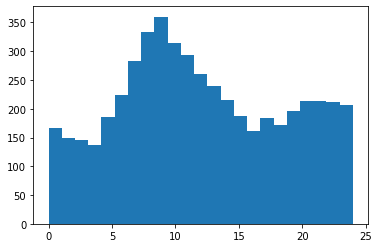

In [119]:
plt.hist(good_exons_phase,bins=int(max(good_exons_phase)))

### Question 2
1. Study the phase relationship between the pre-mRNA and mRNA for genes that you selected to be rhythmic at both the pre-mRNA and mRNA levels. Use cutoffs that give you several hundred genes.
2. Show representative profiles of genes with short or large delays.
3. Analyze the phase difference in function of the ratio of relative amplitudes of the mRNA and pre-mRNA. What is the expected behavior for genes with constant degradation (see course)?  
4. For genes with a positive difference bewteen 0h and 6h, describe whether these follow the prediction.
5. Identify few outliers and discuss them. Can you say something about how these might be regulated?

In [97]:
#Note that because you fitted the log2 data, the relative amplitudes take the form
relamp_exon = 2**amp_exon[ii] - 2**(-amp_exon[ii])
relamp_intron = 2**amp_intron[ii]- 2**(-amp_intron[ii])

NameError: name 'ii' is not defined